# Modelling how a potential loss of activity of the DMSP degrading enzyme over the curse of the experiments may be affecting the fractionation factors

In [31]:
#For numerical calculations
import numpy as np
from scipy.integrate import odeint
import operator 
from scipy.optimize import fsolve
from scipy.stats import linregress
import pandas as pd
import git

# Find home directory for repo
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

#Import plotting features
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns

# Set plot style
sns.set_style("ticks")
sns.set_palette("colorblind", color_codes=True)
sns.set_context("paper")

# Import Interactive widgets library
import panel as pn
pn.extension()

If the enzyme is losing activity, its concentration in the assay tubes is going down over time according to the following equation:

$$
\frac {d[E]}{dt} = -k \;[E]
\tag{1}
$$

In turn, the change in [DMSP] over time will be affected by the decrease in the amount of enzyme:

$$
\frac {d[DMSP]}{dt} = \frac{-V_{max} \;[E]\;[DMSP]}{K_{M}+[DMSP]}
\tag{2}
$$

The above expression for both DMSP isotopologues would be:

$$
\frac {d^{32}[DMSP]}{dt} = \frac{-^{32}V_{max} \;[E]\;^{32}[DMSP]}{^{32}K_{M}+^{32}[DMSP]} =
-\frac{^{32}{V}_{max}}{^{32}K_M}
\left(\frac{^{32}{V}_{max} \;[E] \; {^{32}DMSP}}{^{32}{V}_{max}+\left(
\frac{^{32}{V}_{max}}{^{32}K_M}\right) \; ^{32}DMSP}\right)
\tag{3}
$$

$$
\frac {d^{34}[DMSP]}{dt} = \frac{-^{34}V_{max} \;[E]\;^{34}[DMSP]}{^{34}K_{M}+^{34}[DMSP]} =
-\frac{^{34}{V}_{max}}{^{34}K_M}
\left(\frac{^{34}{V}_{max} \;[E] \; {^{34}DMSP}}{^{34}{V}_{max}+\left(
\frac{^{34}{V}_{max}}{^{34}K_M}\right) \; ^{34}DMSP}\right)
\tag{4}
$$

For simplification, we can define a $\kappa$ parameter equivalent to the ratio of $V_{max}$ and $K_M$:

$$
^{34}{\kappa} = \frac{^{34}{V}_{max}}{^{34}{K}_{M}}
\tag{5}
$$

Replacing 5 in 3 and 4:

$$
\frac {d^{32}[DMSP]}{dt} = -^{32}{\kappa}
\left(\frac{^{32}{V}_{max} \;[E] \; {^{32}DMSP}}{^{32}{V}_{max}+
^{32}{\kappa} \cdot ^{32}DMSP}\right) 
\tag{6}
$$

$$
\frac {d^{34}[DMSP]}{dt} = -^{34}{\kappa}
\left(\frac{^{34}{V}_{max} \;[E] \; {^{34}DMSP}}{^{34}{V}_{max}+
^{34}{\kappa} \cdot ^{34}DMSP}\right) 
\tag{7}
$$

Since the fractionation factors determined in this study could have effects on $V_{max}$, $K_{M}$, or both, they will be equal to:

$$
\alpha = \frac{^{34}{V}_{max}/^{34}{K}_{M}}{^{32}{V}_{max}/^{32}{K}_{M}}
\tag{8}
$$

We show below that the fractionation factors of the enzymes should not be largely affected by a potential loss of activity of the enzyme over the course of the enzyme assays, as exemplified by DddP.
First, we define the function isotopes, which calculates the amount of $^{34}DMSP$ and $^{32}DMSP$ for a given DMSP concentration.

In [32]:
def isotopes(c, r_34_std = 0.0450045, delta_in = 14.3):
    
    '''
    Function that splits a DMSP concentration in the proportion of
    heavy and light atoms.
    Parameters
    ----------
    c: float.
    Concentration of DMSP.
    r_34_std: float.
    34R of the VCDT standard. Error = +-0.0093
    delta_in: float.
    Delta 34S of the DMSP used in the assays for the assays, from Sigma.
    Returns
    -------
    Concentration of 34DMSP, concentration of 32DMSP
    '''
        
    # Calculate 34R in DMSP from Eq. 3
    r_34_dmsp =r_34_std *(1+(delta_in/1000))
    # Calculate 32_DMSP from Eq. 2
    dmsp_32 = c/(1 + r_34_dmsp)
    # Calculate 34_DMSP from Eq. 1
    dmsp_34 = c - dmsp_32
        
    return [dmsp_34,dmsp_32]

Now, we will define a function that will numerically integrate Eqs. 6 and 7 above to calculate $\frac {d^{32}[DMSP]}{dt}$ and $\frac {d^{34}[DMSP]}{dt}$.

In [33]:
def dmsp_enz_deg(
    c, 
    t,   
    alpha,
    vmax,
    vmax_32,
    kappa_32,
    k
):
    """
    Function that computes dD32_dt and dD34_dt of DMSP
    Parameters
    ----------
    c: float.
    Concentration of DMSP in nM.
    t: int
    Integration time in min.
    alpha: float.
    Alpha for cleavage by DddP from this study. 
    vmax: float.
    Vmax for cleavage by DddP, calculated from the K M that the enzyme should have to 
    exhibit the pattern of d34S DMSP vs. time, in nM/min/nM enzyme
    Vmax_d: float.
    km: float.
    K M that the enzyme should have to exhibit the pattern of d34S DMSP vs. time, in nM.
    k: float.
    Degradation rate of the enzyme, in min^-1.

    Returns
    -------
    The dD32_dt and dD34_dt of DMSP
    """

    # Unpack isotopes
    enzyme, dmsp_34, dmsp_32 = c
    
    #Calculate vmax_34 assuming that Vmax total = Vmax_32 + Vmax_34
    #This assumption would only hold true at saturation
    vmax_34 = vmax-vmax_32
    
    #Determination of kappa 32 from kappa 34 and the fractionation factor
    kappa_34 = kappa_32 * alpha
    
    # Calculate dD34_dt
    dD34_dt = - ((kappa_34 * enzyme * (vmax_34 * enzyme * dmsp_34/((vmax_34 * enzyme)+(kappa_34 * enzyme * dmsp_34)))))
    
    # Calculate dD32_dt
    dD32_dt = - ((kappa_32 * enzyme * (vmax_32 * enzyme * dmsp_32/((vmax_32 * enzyme)+(kappa_32 * enzyme * dmsp_32)))))
    
    #Calculate dE_dt
    dE_dt = -k*enzyme

    return [dE_dt, dD34_dt, dD32_dt]

Let's define the parameters for integration. 

In [34]:
# Define parameters for integration

# For DddP (this study)
alpha = (-3.97/1000)+1
# Initial concentration of DMSP in nM
dmsp_init = 207*1000
#Get the isotopic composition of initial DMSP
dmsp_iso_init = isotopes(dmsp_init)
#c[1] is the starting enzyme concentration in nM and c[2] is the starting DMSP concentration in nM
#For DddP
c = (3.479,*dmsp_iso_init)
#For DddP (in nM)
#This is the value of K_M that allows to better reproduce the 
# slope with coherent d34S values of remaining DMSP. Units are nM.
km = 2E9
#Vmax in nM/min/nM enzyme. It will be calculated by reorganizing Eq. 2
# d[DMSP]/dt was assumed to be equal to ([second point] - [first point])/min/enzyme concentration
# In this case, the second point was [DMSP] at t=0 and the first point was [DMSP] at t = 3 min.
vmax=(17000*(dmsp_init+km))/(dmsp_init*c[0])
# Define the 34R of the standard (VCDT)
r_34_std = 0.0450045
#Define the time points for integration
t = np.linspace(0, 53, 50)
#This is the value of V_max calculated using the K_M above, in nM/min/nM enzyme
vmax

47217076.09355234

In [35]:
#This is the ratio of Vmax to K_M (kappa)
kappa = vmax/km
kappa

0.02360853804677617

Now, we will integrate the equations above to understand how a loss of enzyme activity might affect the concentrations of total DMPS, $^{34}DMSP$, and $^{32}DMSP$ over time, as well as the $\delta^{34}S$ values of the remaining DMSP as the reaction proceeds.

In [36]:
#Determine the fractionation by the enzyme when k=0

#k is the rate constant of DMSP loss in min^-1
k = 0
# This is the minimum value that Vmax_32 can have to explain our results,
# considering that 32S is much more abundant than 34S, so Vmax ~ 32Vmax
vmax_32=vmax*0.8
#We will assume that kappa_32 = kappa
kappa_32=kappa
# Group all parameters into args
args = (
    alpha,
    vmax,
    vmax_32,
    kappa_32,
    k
)
# Integrate numerically with ODEint
dmsp_iso = odeint(dmsp_enz_deg, c, t, args=args)

# Split the values returned by the integration, using k=0
enzyme_change_0= dmsp_iso[:,0]
DMSP_34_0 = dmsp_iso[:,1]
DMSP_32_0 = dmsp_iso[:,2]

# Calculate 34R for k=0
r_34_0 = DMSP_34_0/DMSP_32_0

# Calculate d34S and total DMSP for k=0
d34s_0 = (np.divide(r_34_0,r_34_std)-1) * 1000
total_0 = DMSP_34_0+DMSP_32_0

# Calculate the fraction of substrate remaining for k=0
f_r_0 = total_0/dmsp_init
#Determine -ln (f_R) for k=0
minusnatlog_f_r_0 = -np.log(f_r_0)
#Get the slope of the line in a plot of -ln (f_R) vs. the d34s of DMSP,
#equivalent to the fractionation factor without loss of enzyme activity
slope_0, _, _, _, _ = linregress(minusnatlog_f_r_0, d34s_0)

In [37]:
#Determine the fractionation by the enzyme when k is different from 0
#k is the rate constant of DMSP loss in min^-1
k =0.08

# Group all parameters into args
args = (
    alpha,
    vmax,
    vmax_32,
    kappa_32,
    k
)

# Integrate numerically with ODEint
dmsp_iso = odeint(dmsp_enz_deg, c, t, args=args)

# Split the values returned by the integration, using k=!0
enzyme_change_k= dmsp_iso[:,0]
DMSP_34_k = dmsp_iso[:,1]
DMSP_32_k = dmsp_iso[:,2]

# Calculate 34R for k=!0
r_34_k = DMSP_34_k/DMSP_32_k

# Calculate d34S and total DMSP for k=!0
d34s_k = (np.divide(r_34_k,r_34_std)-1) * 1000
total_k = DMSP_34_k+DMSP_32_k

# Calculate the fraction of substrate remaining for k=!0
f_r_k = total_k/dmsp_init
#Determine -ln (f_R) for k=!0
minusnatlog_f_r_k = -np.log(f_r_k)
#Get the slope of the line in a plot of -ln (f_R) vs. the d34s of DMSP,
#equivalent to the fractionation factor with loss of enzyme activity
slope_k, _, _, _, _ = linregress(minusnatlog_f_r_k, d34s_k)

In [13]:
#Let's create a dataframe to store the variables from the inegration before that we
# are interested in plotting
df_DMSP = pd.DataFrame(list(zip(t, DMSP_34_k, DMSP_32_k, total_k,
                               minusnatlog_f_r_k, d34s_k, DMSP_34_0, DMSP_32_0, 
                               total_0, minusnatlog_f_r_0, d34s_0)), 
               columns =['Time', '34DMSP_enz_deg', '32DMSP_enz_deg',
                        'DMSP_total_enz_deg','-ln_fr_enz_deg', 'd34s_enz_deg',
                         '34DMSP_no_enz_deg','32DMSP_no_enz_deg',
                         'DMSP_total_no_enz_deg','-ln_fr_no_enz_deg','d34s_no_enz_deg']) 
df_DMSP.head()

,Time,34DMSP_enz_deg,32DMSP_enz_deg,DMSP_total_enz_deg,-ln_fr_enz_deg,d34s_enz_deg,34DMSP_no_enz_deg,32DMSP_no_enz_deg,DMSP_total_no_enz_deg,-ln_fr_no_enz_deg,d34s_no_enz_deg
0,0.000000,9036.644013,197963.355987,207000.000000,-0.000000,14.300000,9036.644013,197963.355987,207000.000000,-0.000000,14.300000
1,1.081633,8302.226853,181814.739043,190116.965896,0.085079,14.634366,8271.398074,181136.980577,189408.378651,0.088813,14.649060
2,2.163265,7681.277360,168165.306377,175846.583737,0.163107,14.941716,7570.953767,165740.653082,173311.606849,0.177628,14.998983
3,3.244898,7152.713045,156549.947102,163702.660147,0.234667,15.224140,6929.823881,151652.861024,158582.684905,0.266443,15.349708
4,4.326531,6699.998313,146604.007662,153304.005975,0.300296,15.483590,6342.986024,138762.417665,145105.403689,0.355258,15.701176


Let's export the previous dataframe:

In [14]:
df_DMSP.to_csv(f'{homedir}/data/modelling/DMSP_enz_deg.csv')

## Plot change in $^{34}DMSP$, $^{32}DMSP$ and total DMSP without loss of enzyme activity

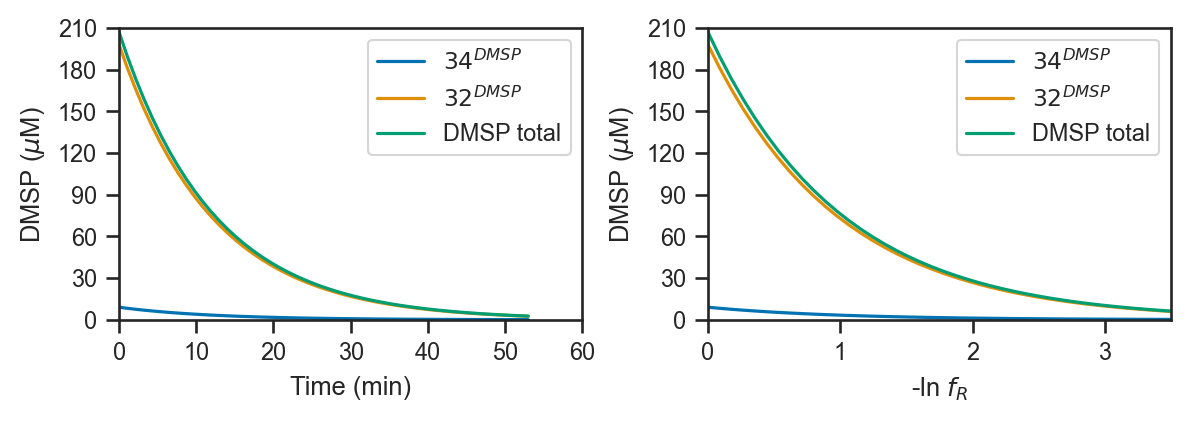

In [133]:
#Create figure
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6, 2), dpi=192)

#Create first plot (left; change in 34DMSP, 32DMSP and total DMSP over time)
ax1.plot(df_DMSP['Time'], df_DMSP['34DMSP_no_enz_deg']/1000)
ax1.plot(df_DMSP['Time'], df_DMSP['32DMSP_no_enz_deg']/1000)
ax1.plot(df_DMSP['Time'], df_DMSP['DMSP_total_no_enz_deg']/1000)
#Set axes labels
ax1.set_xlabel ('Time (min)')
ax1.set_ylabel ('DMSP ($\mu$M)')
#Set axes limits and tick marks
ax1.set_xticks(range(0,70,10))
ax1.set_xlim(0,60)
ax1.set_yticks(range(0,220,30))
ax1.set_ylim(0,210)
#Add legend
ax1.legend(['${34}^{DMSP}$', '${32}^{DMSP}$','DMSP total'])

#Create second plot (right; change in 34DMSP, 32DMSP and total DMSP relative to the fraction of substrate remaining)
ax2.plot(df_DMSP['-ln_fr_no_enz_deg'], df_DMSP['34DMSP_no_enz_deg']/1000)
ax2.plot(df_DMSP['-ln_fr_no_enz_deg'], df_DMSP['32DMSP_no_enz_deg']/1000)
ax2.plot(df_DMSP['-ln_fr_no_enz_deg'], df_DMSP['DMSP_total_no_enz_deg']/1000)
#Set axes labels
ax2.set_xlabel ('-ln $f_{R}$')
ax2.set_ylabel ('DMSP ($\mu$M)')
#Set axes limits and tick marks
ax2.set_xticks(range(0,4))
ax2.set_xlim(0,3.5)
ax2.set_yticks(range(0,220,30))
ax2.set_ylim(0,210)
#Add legend
ax2.legend(['${34}^{DMSP}$', '${32}^{DMSP}$','DMSP total'])
plt.tight_layout(pad=0, w_pad=0.5)

#Save figure
fig.savefig(f'{homedir}/figures/enz_deg/modelling/change_in_dmsp_without_alma1_deg.pdf', bbox_inches='tight')

## Plot change in $^{34}DMSP$, $^{32}DMSP$ and total DMSP with loss of enzyme activity

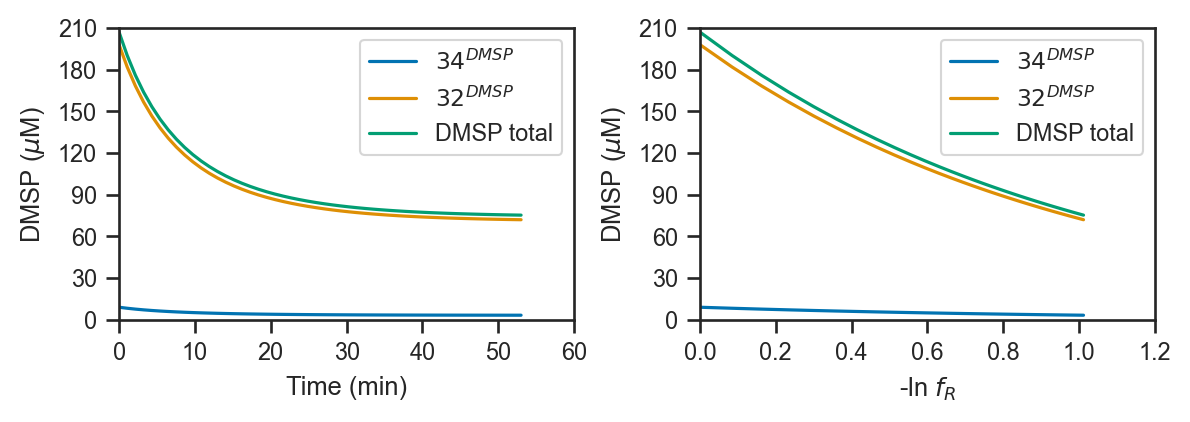

In [12]:
#Create figure
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6, 2), dpi=192)

# Create first plot (left; change in 34DMSP, 32DMSP and total DMSP over time)
ax1.plot(df_DMSP['Time'], df_DMSP['34DMSP_enz_deg']/1000)
ax1.plot(df_DMSP['Time'], df_DMSP['32DMSP_enz_deg']/1000)
ax1.plot(df_DMSP['Time'], df_DMSP['DMSP_total_enz_deg']/1000)
#Set axes labels
ax1.set_xlabel ('Time (min)')
ax1.set_ylabel ('DMSP ($\mu$M)')
#Set axes limits and tick marks
ax1.set_xticks(range(0,70,10))
ax1.set_xlim(0,60)
ax1.set_yticks(range(0,220,30))
ax1.set_ylim(0,210)
#Add legend
ax1.legend(['${34}^{DMSP}$', '${32}^{DMSP}$','DMSP total'])

#Create second plot (right; change in 34DMSP, 32DMSP and total DMSP relative to the fraction of substrate remaining)
ax2.plot(df_DMSP['-ln_fr_enz_deg'], df_DMSP['34DMSP_enz_deg']/1000)
ax2.plot(df_DMSP['-ln_fr_enz_deg'], df_DMSP['32DMSP_enz_deg']/1000)
ax2.plot(df_DMSP['-ln_fr_enz_deg'], df_DMSP['DMSP_total_enz_deg']/1000)
#Set axes labels
ax2.set_xlabel ('-ln $f_{R}$')
ax2.set_ylabel ('DMSP ($\mu$M)')
#Set axes limits and tick marks
ax2.set_xticks([0,0.2,0.4,0.6,0.8,1,1.2])
ax2.set_xlim(0,1.2)
ax2.set_yticks(range(0,220,30))
ax2.set_ylim(0,210)
#Add legend
ax2.legend(['${34}^{DMSP}$', '${32}^{DMSP}$','DMSP total'])
plt.tight_layout(pad=0, w_pad=0.5)

#Save figure
fig.savefig(f'{homedir}/figures/enz_deg/modelling/change_in_dmsp_with_alma1_deg.pdf', bbox_inches='tight')

We will now make the Rayleigh distillation plots ($\delta^{34}S$  vs. -ln of the fraction of DMSP remaining) for constant enzyme activity and loss of enzyme activity (left), and a plot of $\delta^{34}S$ vs. time (right) for both the modelling with and without enzyme activity, with the data with the data on top. Let's import the data for DddP.

In [16]:
# Import table with the raw data for DddP
df_dddp = pd.read_csv(f'{homedir}/data/processed/enzymes/dddp_master.csv')
df_dddp.head()

,Unnamed: 0,Name,d34S,Replicate,Time_min,ID,f_R,Real_conc,minus_ln_f_R,d34S_approx,r34_approx,f34_approx,conc_s_cell_lysate,F34_approx_DMSP,R34_approx_DMSP,d34S_approx_DMSP
0,0,DddP,10.820000,a,0,DddP_0_a,1.000000,207.193975,0.000000,10.761883,0.045489,0.043510,263.586963,0.043655,0.045648,14.291178
1,1,DddP,10.946961,a,3,DddP_3_a,0.861376,178.471949,0.149224,10.887477,0.045494,0.043515,263.586963,0.043691,0.045687,15.170456
2,2,DddP,10.464305,a,15,DddP_15_a,0.512602,106.208079,0.668255,10.409933,0.045473,0.043495,263.586963,0.043743,0.045744,16.421836
3,3,DddP,10.620075,a,25,DddP_25_a,0.468065,96.980176,0.759149,10.564078,0.045480,0.043501,263.586963,0.043790,0.045795,17.567484
4,4,DddP,10.673636,a,38,DddP_38_a,0.422335,87.505211,0.861957,10.617075,0.045482,0.043504,263.586963,0.043830,0.045839,18.538837


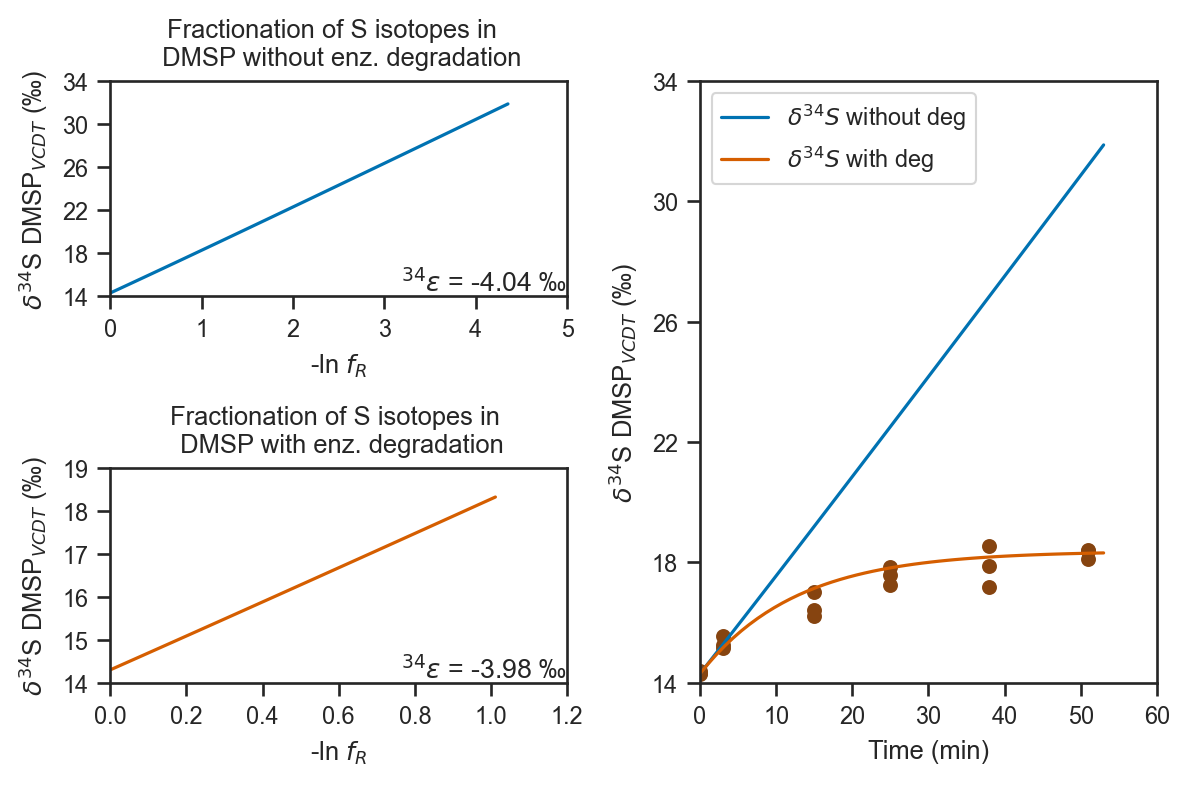

In [19]:
#Create figure

fig = plt.figure(figsize=(6.1, 4), dpi=192)

ax1 = plt.subplot(221)
ax2 = plt.subplot(223)
ax3 = plt.subplot(122)

#Assing plots to axes
ax1.plot(df_DMSP['-ln_fr_no_enz_deg'], df_DMSP['d34s_no_enz_deg'], color ='#0072B2')
ax2.plot(df_DMSP['-ln_fr_enz_deg'], df_DMSP['d34s_enz_deg'], color='#D55E00')
ax3.plot(df_DMSP['Time'], df_DMSP['d34s_no_enz_deg'], 
label ='$\delta^{34}{S}$ without deg', color ='#0072B2')
ax3.plot(df_DMSP['Time'], df_DMSP['d34s_enz_deg'], 
label='$\delta^{34}{S}$ with deg', color ='#D55E00')
    
#Add axes labels and legends to the first plot
ax1.set_ylabel ('$\delta ^{34}$S DMSP$_{VCDT}$ (‰)')
ax1.set_xlabel ('-ln $f_{R}$')
ax1.set_yticks(np.linspace(14,28,5))

ax1.set_title('Fractionation of S isotopes in  \n DMSP without enz. degradation')
ax1.set_xticks(range(0,6))
ax1.set_xlim(0,5)
ax1.set_yticks(range(14,35,4))
ax1.set_ylim(14,34)
#Add epsilon
ax1.text(1, 0, '$^{34}$$\epsilon$ = %s ‰' %(-slope_0.round(2)), transform=ax1.transAxes,
    verticalalignment='bottom', horizontalalignment='right', fontsize=10)

#Add axes labels and legends to the second plot
ax2.set_ylabel ('$\delta ^{34}$S DMSP$_{VCDT}$ (‰)')
ax2.set_xlabel ('-ln $f_{R}$')
ax2.set_ylim (14,19)
ax2.set_title('Fractionation of S isotopes in \n DMSP with enz. degradation')
ax2.set_xticks([0,0.2,0.4,0.6,0.8,1,1.2])
ax2.set_xlim(0,1.2)
ax2.set_yticks(range(14,20,1))
ax2.set_ylim(14,19)
#Add epsilon
ax2.text(1, 0, '$^{34}$$\epsilon$ = %s ‰' %(-slope_k.round(2)), transform=ax2.transAxes,
    verticalalignment='bottom', horizontalalignment='right', fontsize=10)

#Add axes labels and legends
ax3.set_xlabel ('Time (min)')
ax3.set_ylabel ('$\delta ^{34}$S DMSP$_{VCDT}$ (‰)')
ax3.set_xlim (0,60)
ax3.set_yticks(range(14,35,4))
ax3.set_ylim (14,34)
ax3.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

#Plot the DddP data on top
# Group by replicate
df_group = df_dddp.groupby(['Replicate'])
# Define colors

# Loop through replicates
for i, (group, data) in enumerate(df_group):

#Plot experimental data
    ax3.scatter(data.Time_min, data.d34S_approx_DMSP, color = '#864410')

#Show legend
ax3.legend()
#Adjust figure dimensions and save figure
plt.tight_layout(pad=0.4, w_pad=1, h_pad=1)

#Save figure
fig.savefig(f'{homedir}/figures/enz_deg/modelling/fit_d34s_enz_deg.pdf', bbox_inches='tight')

Below, we will examine how different enzyme degradation rates would affect the $^{34}\varepsilon$ of DddP at a constant $V_{max}$.

In [42]:
#Create an array with a range of enzyme degradation rates
k = np.linspace (0,1,100)

#Define Vmax and 32^Vmax for cleavage by DddP in nmol/min/mg enz
vm=vmax
vmax_32=vmax*0.8

#Integrate
#Initialize empty lists
slopes = []
k_x = []
#Loop through the enzyme degradation rates
for i in k:
    # Group all parameters into args
    args = (
    alpha,
    vm,
    vmax_32,
    kappa_32,
    i
    )
    # Integrate numerically with ODEint
    dmsp_iso = odeint(dmsp_enz_deg, c, t, args=args)
    # Split the values returned by the integration
    enzyme_change= dmsp_iso[:,0]
    DMSP_34 = dmsp_iso[:,1]
    DMSP_32 = dmsp_iso[:,2]
    # Calculate 34R
    r_34 = DMSP_34/DMSP_32
    # Calculate d34S and total DMSP
    d34s = (np.divide(r_34,r_34_std)-1) * 1000
    lin_app_d34s = 1000*np.log(1+d34s/1000)
    total = DMSP_34+DMSP_32
    #Calculate the fraction of reactant remaining
    f_r = total/dmsp_init
    #Determine -ln (f_R)
    minusnatlog_f_r = -np.log(f_r)
    
    #Get the slope of the line in a plot of -ln (f_R) vs. the linear approximation to the d34s of DMSP,
    #equivalent to the fractionation factor
    slope, _, _, _, _ = linregress(minusnatlog_f_r, lin_app_d34s)
    #Append the fractionation factors for different rates of enzyme degradation to the previously created empty list
    slopes.append(slope)
    #Append the rate of enzyme degradation to the previously created empty list
    k_x.append (i)
    
#Send slopes and rates of enzyme degradation to a new dataframe
df_34e_variable_enz_deg_rates = pd.DataFrame(list(zip(k_x,slopes)), 
               columns =['Rates_of_enz_deg','34epsilon']) 
df_34e_variable_enz_deg_rates.head()

,Rates_of_enz_deg,34epsilon
0,0.000000,3.952548
1,0.010101,3.947038
2,0.020202,3.941272
3,0.030303,3.935583
4,0.040404,3.930209


In [43]:
#Export dataframe to csv
df_34e_variable_enz_deg_rates.to_csv(f'{homedir}/data/modelling/34e_variable_enz_deg_rates.csv')

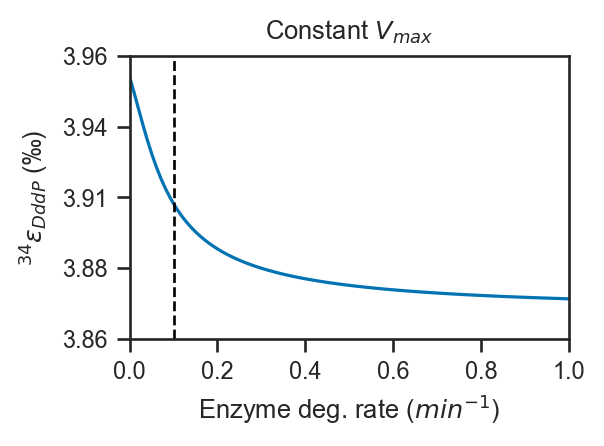

In [52]:
#Create figure    
fig, ax = plt.subplots(figsize=(2.95, 1.95), dpi=192)
#Plot the enzyme degradation rates vs. the linear approximation to the d34s of DMSP
plt.plot(df_34e_variable_enz_deg_rates['Rates_of_enz_deg'], df_34e_variable_enz_deg_rates['34epsilon'])
#slopes = np.asarray(slopes)

#Adjust y axis tick marks and decimal places
ax.set_yticks(np.linspace(3.86,3.96,5))
ax.set_xlim (0,1)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))

#Add title and axes labels
plt.title ('Constant $V_{max}$')
plt.xlabel ('Enzyme deg. rate ($min^{-1}$)')
plt.ylabel ('$^{34}\epsilon_{DddP}$ (‰)')

#Include a line that demarks the maximum enzyme degradation rate for any of the enzymes included in this study,
#according to the curvature of the experimental data of linear approximation to the d34s of DMSP vs. time
ax.axvline(linewidth=1, x = 0.1, color='black', linestyle='--')

#Save figure
fig.savefig(f'{homedir}/figures/enz_deg/modelling/change_in_34epsilon_variable_enz_deg_rates.pdf', bbox_inches='tight')

The dotted vertical line corresponds to an enzyme degradation rate of $0.1 {min}^{-1}$. In our enzyme assays, no enzyme is exceeding this value. Otherwise, the fit of the data of $\delta^{34}S$ of DMSP vs. time would be  a line that flattens very early during the experiments, rendering almost no fractionations, contrary to our observations. It can then be observed that, at such low degradation rates, the $\delta^{34}S$ of DMSP at any measured point would vary by less than 0.06‰ relative to the one expected from an assay where no enzyme loss ocurred.

Next, we will examine how changing the $^{32}V_{max}$ at a constant rate of enzyme loss would affect the $^{34}\varepsilon_{DddP}$ (‰).

In [45]:
#We will assume that kappa_32 = kappa
kappa_32=kappa
#Create array of 32^Vmax for cleavage by DddP in nmol/min/mg enz
vmax_32 = np.linspace (1E6,1E9,100)
vm=2E9
#Define enzyme degradation rate in min^-1
k=0.08

#Integrate
#Initialize empty lists
slopes = []
vmax_32_x = []
#Loop through the enzyme degradation rates
for i in vmax_32:
    # Group all parameters into args
    args = (
    alpha,
    vm,
    i,
    kappa_32,
    k
    )
    # Integrate numerically with ODEint
    dmsp_iso = odeint(dmsp_enz_deg, c, t, args=args)
    # Split the values returned by the integration
    enzyme_change= dmsp_iso[:,0]
    DMSP_34 = dmsp_iso[:,1]
    DMSP_32 = dmsp_iso[:,2]
    # Calculate 34R
    r_34 = DMSP_34/DMSP_32
    # Calculate d34S and total DMSP
    d34s = (np.divide(r_34,r_34_std)-1) * 1000
    lin_app_d34s = 1000*np.log(1+d34s/1000)
    total = DMSP_34+DMSP_32
    #Calculate the fraction of reactant remaining
    f_r = total/dmsp_init
    #Determine -ln (f_R)
    minusnatlog_f_r = -np.log(f_r)
    
    #Get the slope of the line in a plot of -ln (f_R) vs. the linear approximation to the d34s of DMSP,
    #equivalent to the fractionation factor
    slope, _, _, _, _ = linregress(minusnatlog_f_r, lin_app_d34s)
    #Append the fractionation factors for different Vmax to the previously created empty list
    slopes.append(slope)
    #Append the Vmax to the previously created empty list
    vmax_32_x.append (i)
    
#Send slopes and 32^V_max to a new dataframe
df_34e_variable_32vmax = pd.DataFrame(list(zip(vmax_32_x,slopes)), 
               columns =['32vmax','34epsilon']) 
df_34e_variable_32vmax.head()

,32vmax,34epsilon
0,1.000000e+06,1.331407
1,1.109091e+07,3.733105
2,2.118182e+07,3.846326
3,3.127273e+07,3.886477
4,4.136364e+07,3.907037


In [46]:
#Export dataframe to csv
df_34e_variable_32vmax.to_csv(f'{homedir}/data/modelling/34e_variable_32vmax.csv')

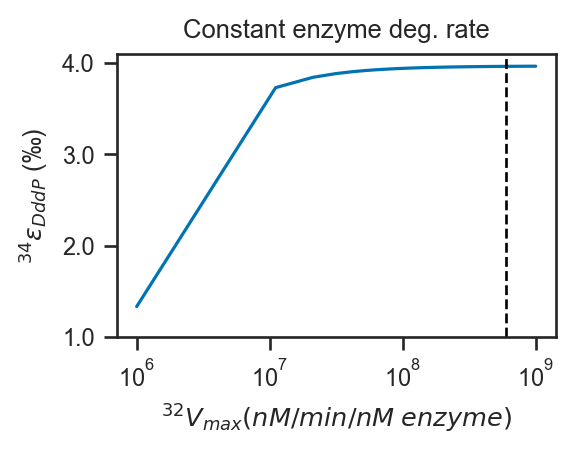

In [47]:
#Create figure    
fig, ax = plt.subplots(figsize=(2.95, 1.95), dpi=192)
#Plot the Vmax vs. the linear approximation to the d34s of DMSP
plt.plot(df_34e_variable_32vmax['32vmax'], df_34e_variable_32vmax['34epsilon'])

#Adjust y axis tick marks and decimal places
#ax.set_yticks(np.linspace(3.95,3.97,3))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))
ax.set_xscale('log')
plt.minorticks_off()
ax.axvline(linewidth=1, x = vm*0.3, color='black', linestyle='--')
ax.set_xticks(np.geomspace(1E6,1E9,4))
ax.set_yticks(np.linspace(1,4,4))
#Add title and axes labels
plt.title ('Constant enzyme deg. rate')
plt.xlabel ('$^{32}V_{max}  (nM/min/nM\;enzyme)$')
plt.ylabel ('$^{34}\epsilon_{DddP}$ (‰)')

#Save figure
fig.savefig(f'{homedir}/figures/enz_deg/modelling/change_in_34epsilon_32vmax.pdf', bbox_inches='tight')

In the plot above, we can see that changing $^{32}V_{max}$ at a constant enzyme loss rate would shift the $\delta^{34}S$ of DMSP. However, since $^{32}DMSP$ is much more abundant than $^{34}DMSP$, we would not expect its contribution towards the total $V_{max}$ to be less than 80%. The dotted line above is at $^{32}V_{max}$ = 30% of $V_{max}$. At $^{32}V_{max}$ above that line, there is little change in the $\delta^{34}S$ of DMSP.

Now, we will examine how changing the $^{32}V_{max}/^{32}K_M$ at a constant rate of enzyme loss and a $^{32}V_{max}$ = $V_{max}$ *0.8 would affect the $^{34}\varepsilon_{DddP}$ (‰).

In [48]:
#Create an array with a range of kappa_32 values
kappa_32 = np.linspace (1E-5,5E-1,100)
#Set Vmax
vm=vmax
vmax_32=vm*0.8
#Define enzyme degradation rate in min^-1
k=0.08

#Integrate
#Initialize empty lists
slopes = []
kappa_32_x = []
#Loop through the enzyme degradation rates
for i in kappa_32:
    # Group all parameters into args
    args = (
    alpha,
    vm,
    vmax_32,
    i,
    k
    )
    # Integrate numerically with ODEint
    dmsp_iso = odeint(dmsp_enz_deg, c, t, args=args)
    # Split the values returned by the integration
    enzyme_change= dmsp_iso[:,0]
    DMSP_34 = dmsp_iso[:,1]
    DMSP_32 = dmsp_iso[:,2]
    # Calculate 34R
    r_34 = DMSP_34/DMSP_32
    # Calculate d34S and total DMSP
    d34s = (np.divide(r_34,r_34_std)-1) * 1000
    lin_app_d34s = 1000*np.log(1+d34s/1000)
    total = DMSP_34+DMSP_32
    #Calculate the fraction of reactant remaining
    f_r = total/dmsp_init
    #Determine -ln (f_R)
    minusnatlog_f_r = -np.log(f_r)
    
    #Get the slope of the line in a plot of -ln (f_R) vs. the linear approximation to the d34s of DMSP,
    #equivalent to the fractionation factor
    slope, _, _, _, _ = linregress(minusnatlog_f_r, lin_app_d34s)
    #Append the fractionation factors for different Vmax to the previously created empty list
    slopes.append(slope)
    #Append the Vmax to the previously created empty list
    kappa_32_x.append (i)

#Send slopes and 32^V_max to a new dataframe
df_34e_variable_32ratio = pd.DataFrame(list(zip(kappa_32_x,slopes)), 
               columns =['32ratio','34epsilon']) 
df_34e_variable_32ratio.head()

,32ratio,34epsilon
0,0.000010,3.970645
1,0.005060,3.951654
2,0.010111,3.937100
3,0.015161,3.926083
4,0.020212,3.917875


In [50]:
#Export dataframe to csv
df_34e_variable_32ratio.to_csv(f'{homedir}/data/modelling/34e_variable_32ratio.csv')
df_34e_variable_32ratio.head()

,32ratio,34epsilon
0,0.000010,3.970645
1,0.005060,3.951654
2,0.010111,3.937100
3,0.015161,3.926083
4,0.020212,3.917875


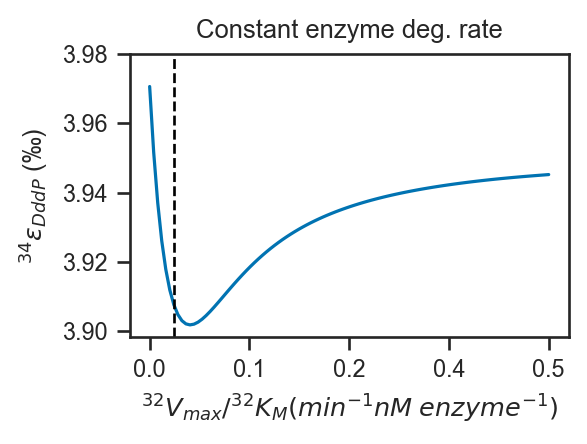

In [51]:
#Create figure    
fig, ax = plt.subplots(figsize=(2.95, 1.95), dpi=192)
#Plot the Vmax vs. the linear approximation to the d34s of DMSP
plt.plot(df_34e_variable_32ratio['32ratio'], df_34e_variable_32ratio['34epsilon'])

# #Adjust y axis tick marks and decimal places#ax.set_yticks(np.linspace(3.9,3.98,5))
ax.set_xticks(np.linspace(0,0.5,5))
ax.set_yticks(np.linspace(3.9,3.98,5))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))
# #Add title and axes labels
plt.title ('Constant enzyme deg. rate')
plt.xlabel ('$^{32}V_{max}/^{32}K_{M} (min^{-1}nM\;enzyme^{-1})$')
plt.ylabel ('$^{34}\epsilon_{DddP}$ (‰)')
ax.axvline(linewidth=1, x = 0.03, color='black', linestyle='--')

#Save figure
fig.savefig(f'{homedir}/figures/enz_deg/modelling/change_in_34epsilon_with_32ratio.pdf', bbox_inches='tight')

The dotted line is drawn at a ratio of $^{32}V_{max}/^{32}K_{M}$ of 0.3. None of the values tested in our model exceeded 0.05. The range of possible values of $\delta ^{34}$S of DMSP with a change in $^{32}V_{max}/^{32}K_{M}$ would then expected to be less than 0.08 ‰